<a href="https://colab.research.google.com/github/csaybar/EEwPython/blob/master/cnn_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--COURSE_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://sitejerk.com/images/google-earth-logo-png-5.png" width=5% >
<img align="right" style="padding-left:10px;" src="https://colab.research.google.com/img/colab_favicon_256px.png" width=6% >


>> *This notebook is part of the free course [EEwPython](https://colab.research.google.com/github/csaybar/EEwPython/blob/master/index.ipynb); the content is available [on GitHub](https://github.com/csaybar/EEwPython)* and released under the [Apache 2.0 License](https://www.gnu.org/licenses/gpl-3.0.en.html). 

<!--NAVIGATION-->
 < [Crop Area Prediction Using a Deepl Neural Network](dnn_demo.ipynb) | [Contents](index.ipynb) | >

<a href="https://colab.research.google.com/github/csaybar/EEwPython/blob/master/dnn_demo.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<center>
<h1>Google Earth Engine with Python </h1>
<h2> Integrating Earth Engine with Tensorflow II - U-Net </h2>
</center>

This notebook has been inspired by the [Chris Brown & Nick Clinton EarthEngine + Tensorflow presentation](https://www.youtube.com/watch?v=w-1xfF0IaeU). It shows the step by step how to integrate Google Earth Engine and TensorFlow 2.0 in the same pipeline (EE->Tensorflow->EE).

```
FILE: cnn_demo.ipynb
AUTHOR: Cesar Aybar
EMAIL: csaybar@gmail.com
ORGANIZATION: n/a 
MODIFIED BY: n/a
CREATION DATE: 16 Jun. 2019
LAST MOD DATE: N/A
DEPENDENCIES: earthengine-api, os, pandas, urllib, plotly, numpy, folium
PURPOSE: Introduction to tensorflow & GEE integration
```

<center>
<img src="https://raw.githubusercontent.com/csaybar/EEwPython/master/images/colab_ee_integration.png">
</center>  

OBS: I will assume that the reader is already familiar with the basic concepts of Machine Learning and Convolutional Networks. If it is doesn't, I firstly highly recommend taking the deep learning coursera specialization available [here.](https://www.coursera.org/specializations/deep-learning)




## Topics

1. Create a training/testing dataset (in a TFRecord format) using Earth Engine.
2.  Create functions for parse data (TFRecord -> tf.data.Dataset; Decode the bytes into an image format).
3. Shuffle, repeat and batch the data.
4.   Training and Test a Convolutional Neuronal Network using tensorflow 2.0.
5.   Making predictions on image data exported from Earth Engine in TFRecord format.
6.   Upload your results to Earth Engine (asset).


## 1. Introduction

Deep learning has dramatically improved the state-of-the-art in various science domains. For remote sensing, its potential has not been thoroughly explored yet. This could be related to the problematic incorporation of spectral & spatial features into a regular deep learning classification scheme or for the huge pre-processing that satellite images could need it.

Hence, this post aims to teach you how to create a painless deep learning workflow integrating [Google Earth engine](https://earthengine.google.com/) for acquiring spectral & spatial data and [tensorflow](https://www.tensorflow.org/?hl=en) for train and test the model and make predictions.



## 2. What is Google Earth Engine (GEE)?

In a nutshell, is a platform that combines a multi-petabyte [catalog of satellite imagery](https://developers.google.com/earth-engine/datasets/) with planetary-scale analysis capabilities. There are several ways to interact with GEE:

  - [Explorer](https://explorer.earthengine.google.com/)
  - [Code Editor](https://code.earthengine.google.com/)  
  - [Javascript wrapper library](https://github.com/google/earthengine-api/tree/master/javascript)
  - [**Python wrapper library**](https://github.com/google/earthengine-api/tree/master/python)

In my opinion, the **Python wrapper library** (used in this post) is the best choice to interact with GEE for the following reasons:

- Easy to share code.
- Easy transition to a web application.
- Possibility to integrate with  ML/DL frameworks.
- Many plotting options (folium, plotly, matplotlib, seaborn ,etc.).

One more thing!, it's possible to run the Earth Engine Python API in a cloud environment for free. See the introduction of this [course](https://colab.research.google.com/github/csaybar/EEwPython/blob/dev/1_Introduction.ipynb) for more details.


## 3.  U-net: Convolutional Networks for Biomedical Image Segmentation - Adapted from the [Harshall Lamba post](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47) 

There are various levels of granularity in which the computers can gain an understanding of images. For each of these levels there is a problem defined in the [Computer Vision](https://en.wikipedia.org/wiki/Computer_vision) domain. Starting from a coarse grained down to a more fine grained understanding we can identify the following problems.

- Classification with Localization
- Object Detection
- **Semantic Segmentation**
- Instance segmentation


<center>
<image src="https://cdn-images-1.medium.com/max/800/1*SNvD04dEFIDwNAqSXLQC_g.jpeg" width=50%>
</center>

As you can see, a typical remote sensing classification task search the same thing than a semantic segmentation problem. One of the most popular state-of-art CNN used in semantic segmentation is the **U-Net** (it will be used in this post) initially developed for biomedical image interpretation. This network is a slight modification of the [fully convolutional network (FCN)](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf). 
 Inside the U-Net architecture exist two contrasting parts (see image below). The first one is the contraction path (also called as **encoder**) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max-pooling layers. The second path is the symmetric expanding path (also called as **decoder**) which is used to enable precise localization using transposed convolutions. Unlike the original model, we will add [batch normalization](https://en.wikipedia.org/wiki/Batch_normalization) to each of our blocks.     
  
<center>
<image src="https://cdn-images-1.medium.com/max/1600/1*OkUrpDD6I0FpugA_bbYBJQ.png" width=70%>
</center>
  
The main steps for building a U-net are:
  
1. Create the dataset considering patch of 256x256.
2. Visualize data/perform some exploratory data analysis.
3. Set up data pipeline and preprocessing.
4. Initialize the model's parameters.
5. Loop:
    - Calculate current loss (forward propagation) :    
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

The five step could be  a little intimidating, but don't worry about it!. **tf.keras**, the TensorFlow's high-level API, only need that you define the forward propagation correctly and all the steps further down will make automatically. This post does not intend to introduce the algorithm, check out this [repo](https://github.com/jakeret/tf_unet) for a from zero (tensorflow) implementation.

## 4. Crop Area estimation in Camana Valley (DEMO)

Agriculture is part of the backbone Peruvian economy, contributing about 7.6% of the Gross Domestic Product (GDP), being more critical in rural areas where the contribution of GDP increase until 50%. In terms of people, this activity act for the primary source of income for 2.3 million families, representing 34% of Peruvian households. Despite agriculture importance in Peruvian family lives, today no exist a cropping system either at a national or regional scale that monitoring the extension, state, or crop type. Considering this problematic, in this section **you** will create a straightforward methodology to **predict the crop area** in Camana (Arequipa) Valley using the CNN above described.

<center>
<img src='https://st.depositphotos.com/1171712/3974/i/950/depositphotos_39741899-stock-photo-camana-valley.jpg'>
</center>


In [0]:
#@title Mapdisplay: Display ee.Features and ee.Images using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = EE_TILES.format(**v),
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

### 4.1. Installing

Before coding does not forget install and load the following packages and remember that you can communicate with the bash console prepending an ! to the code. 




In [0]:
!pip install tf-nightly-2.0-preview==2.0.0.dev20190606  #tensorflow 2.0
!pip install earthengine-api==0.1.175 #earthengine API
# Load the TensorBoard notebook extension
%load_ext tensorboard

### 4.2. Authentification

This tutorial needs interacting with some Google services. For accomplish this task, it's necessary to authenticate (as yourself). The code below shows you how to do it.

#### Google Cloud

Google Cloud Storage bucket will serve as a bridge between GEE and Colab.


In [0]:
from google.colab import auth
auth.authenticate_user()

#### Google Earth Engine

In [0]:
!earthengine authenticate

### 4.3. Initialize and testing the software setup



In [0]:
# Earth Engine Python API
import ee 
ee.Initialize()

import tensorflow as tf
print('Tensorflow version: ' + tf.__version__)

import folium
print('Folium version: ' + folium.__version__)

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

Tensorflow version: 2.0.0-dev20190606
Folium version: 0.8.3


### 4.4. Prepare the Dataset

Firstly, we define our prediction area (Camana Valley) and passing to GEE. For moving a vector to GEE, you will use the `ee.Geometry.*` module. The [GeoJSON](https://geojson.org/) spec describes in detail the type of geometries supported by GEE, including `Point` (a list of coordinates in some projection), `LineString` (a list of points), `LinearRing` (a closed LineString), and `Polygon` (a list of LinearRings where the first is a shell and subsequent rings are holes). GEE also supports **MultiPoint**, **MultiLineString**, and **MultiPolygon**. The [GeoJSON](https://geojson.org/) GeometryCollection is also supported, although it has the name **MultiGeometry** within GEE.

In [0]:
# 2.4.1 Prediction Area
xmin,ymin,xmax,ymax = [-72.778645, -16.651663, -72.66865, -16.57553]


# Passing a rectangle (prediction area) to Earth Engine
Camana_valley = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])
center = Camana_valley.centroid().getInfo()['coordinates']
center.reverse()
Mapdisplay(center,{'Camana Valley':Camana_valley.getInfo()},zoom_start=12)

Next, you will read and create a visualization of the train/test dataset. I've already generated some points with the label agriculture/non-agriculture.

- Train dataset (550 points):
  - 275 labeled as "agriculture"
  - 275 labeled as "non agriculture" 
  
- Test dataset (100 points):
  - 50  labeled as "agriculture"
  - 50  labeled as "non agriculture"

In [0]:
# 2.4.2 Importing the train/test dataset
train_agriculture = ee.FeatureCollection('users/csaybar/DLdemos/train_set') 
test_agriculture = ee.FeatureCollection('users/csaybar/DLdemos/test_set')

# Display the train/test dataset
db_crop = train_agriculture.merge(test_agriculture)
center = db_crop.geometry().centroid().getInfo()['coordinates']
center.reverse()

dicc = {'train': train_agriculture.draw(**{'color': 'FF0000', 'strokeWidth': 5}).getMapId(),
        'test' : test_agriculture.draw(**{'color': '0000FF', 'strokeWidth': 5}).getMapId(),
        'CamanaValley':Camana_valley.getInfo()
       }

Mapdisplay(center,dicc,zoom_start=8)

For train the model, unlike the [first post](https://csaybar.github.io/post/eetf/), you will use the **Cultivated Lands class (raster)**  of the  [GLC30](https://www.sciencedirect.com/science/article/pii/S0924271614002275), it is a relative new Global Land Cover product at 30-meter spatial resolution.


In [0]:
from collections import OrderedDict

# Load the dataset
glc30 = ee.ImageCollection('users/csaybar/GLC30PERU').max().eq(10).rename('target')

# Vizualize the dataset

glc30id = glc30.getMapId()
dicc['glc30'] = glc30id
# Changing the order of the dictionary
key_order = ['glc30','CamanaValley','train','test']
dicc = OrderedDict((k, dicc[k]) for k in key_order)

Mapdisplay(center,dicc,zoom_start=8)

At this part, you will obtain the input data for mapping the **Camana crop area** from  [Landsat ETM sensor (L5)](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR). GEE provides L5 images with radiometric and geometry correction. Additionally, **cloud mask information** is supplied employing the bit image `pixel_qa`. The following function allows putting NA to the TOA reflectance values of clouds.



In [0]:
def maskS2clouds(img):
  '''  
  Function to mask clouds based on the pixel_qa band of Landsat 5 data. See:
  https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LT05_C01_T1_SR
  
  Params:
  -------
  - img: image input Landsat 5 SR image
  
  Return:
  -------
  cloudmasked Landsat 5 image
  '''
  qa = img.select('pixel_qa')
  cloud = qa.bitwiseAnd(1 << 5)\
            .And(qa.bitwiseAnd(1 << 7))\
            .Or(qa.bitwiseAnd(1 << 3))
  mask2 = img.mask().reduce(ee.Reducer.min())
  return img.updateMask(cloud.Not()).updateMask(mask2)

Now you will filter and reduce the entire Landsat-8 dataset, considering the following:

1. Select just bands **[R, G, B, NIR]**.

2. Filter considering the cloud pixel percentage by scene (< 20%).

3. Filter considering a date (we just selecting 1 year)

4. Apply **mask2cloud** to each image.

5. Get the median of the ImageCollection.

6. Clip the image considering the study area.

**NOTE:** To apply a function on all the elements of specified **`ImageCollection`** or **`FeatureCollection`**, you can use the **`map()`** function. 

In [0]:
# 2.4.3 Prepare the satellite image (Landsat-8)
RGB_bands = ['B3','B2','B1'] #RGB
NDVI_bands = ['B4','B3'] #NIR

l5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")\
               .filterBounds(db_crop)\
               .filterDate('2005-01-01', '2006-12-31')\
               .filter(ee.Filter.lt('CLOUD_COVER', 20))\
               .map(maskS2clouds)\
               .median()\
               .multiply(0.0001)

l5_ndvi = l5.normalizedDifference(NDVI_bands).rename(['NDVI'])
l5_rgb = l5.select(RGB_bands).rename(['R','G','B']) 
l5 = l5_rgb.addBands(l8_ndvi).addBands(glc30)

In [0]:
from collections import OrderedDict
# Create a visualization with folium
visParams_l5 = {    
  'bands': ['R', 'G', 'B'],
  'min': 0,
  'max': 0.5,
  'gamma': 1.4,
}

l5Mapid = l5.getMapId(visParams_l5)
dicc['Landsat5'] = l8Mapid

# Changing the order of the dictionary
key_order = ['Landsat5','glc30','CamanaValley','train','test']
dicc = OrderedDict((k, dicc[k]) for k in key_order)

Mapdisplay(center,dicc,zoom_start=8)

The key to success for integrating GEE with a CNN pipeline is the **ee.Image.neighborhoodToArray** function. It turns the neighborhood of each pixel in a scalar image into a 2D array (see image below). Axes 0 and 1 of the output array correspond to Y and X axes of the image, respectively. The output image will have as many bands as the input; each output band has the same mask as the corresponding input band. The footprint and metadata of the input image are preserved.

<center>
<img src = "https://raw.githubusercontent.com/csaybar/csaybar.github.io/master/img/neighborhoodToArray.png">
</center>

There are several restrictions about the max number of features that a [table can save](https://developers.google.com/earth-engine/exporting#exporting-tables-and-vector-data) (~ 10 M). For this reason, the **saveCNN_batch** function is created as below:


In [0]:
import numpy as np
import time

def saveCNN_batch(image, point,kernel_size,scale,FilePrefix, selectors,folder, bucket='bag_csaybar'):
  """
    Export a dataset for semantic segmentation by batches
  
  Params:
  ------
    - image : ee.Image to get pixels from; must be scalar-valued.
    - point : Points to sample over.
    - kernel_size : The kernel specifying the shape of the neighborhood. Only fixed, square and rectangle kernels are supported.
      Weights are ignored; only the shape of the kernel is used.
    - scale : A nominal scale in meters of the projection to work in.
    - FilePrefix : Cloud Storage object name prefix for the export.
    - selector : Specified the properties to save.
    - bucket : The name of a Cloud Storage bucket for the export.  
  """
  print('Found Cloud Storage bucket.' if tf.io.gfile.exists('gs://' + bucket) 
    else 'Output Cloud Storage bucket does not exist.')
  
  # Download the points (Server -> Client)
  nbands = len(selectors)
  points = train_agriculture.geometry().getInfo()['coordinates']    
  nfeatures = kernel_size*kernel_size*nbands*len(points) #estimate the totals # of features
     
  image_neighborhood = image.neighborhoodToArray(ee.Kernel.rectangle(kernel_size, kernel_size, 'pixels'))
  filenames = []
  
  #Threshold considering the max number of features permitted to export.
  if nfeatures > 3e6:
    nparts = int(np.ceil(nfeatures/3e6))
    print('Dataset too long, splitting it into '+ str(nparts),'equal parts.')
    
    nppoints = np.array(points)
    np.random.shuffle(nppoints)
    
    count_batch = 1  # Batch counter 
    
    for batch_arr in np.array_split(nppoints,nparts):
      
      fcp = ee.FeatureCollection([
          ee.Feature(ee.Geometry.Point(p),{'class':'NA'}) 
          for p in batch_arr.tolist() 
      ])
      
      # Agriculture dataset (fcp-points) collocation to each L5 grid cell value.
      train_db = image_neighborhood.sampleRegions(collection=fcp, scale=scale)
      filename = '%s/%s-%04d_' % (folder,FilePrefix,count_batch)
      
      # Create the tasks for passing of GEE to Google storage
      print('sending the task #%04d'%count_batch)
      Task = ee.batch.Export.table.toCloudStorage(
        collection=train_db,        
        selectors=selectors,          
        description='Export batch '+str(count_batch),
        fileNamePrefix=filename,
        bucket=bucket,  
        fileFormat='TFRecord')
      
      Task.start()
      filenames.append(filename)
      count_batch+=1
      
      while Task.active():
        print('Polling for task (id: {}).'.format(Task.id))
        time.sleep(3)
        
    return filenames
  
  else:    
    train_db = image_neighborhood.sampleRegions(collection=points, scale=scale)         
    Task = ee.batch.Export.table.toCloudStorage(
      collection=train_db,
      selectors=selectors,
      description='Training Export',
      fileNamePrefix=FilePrefix,
      bucket=bucket,  
      fileFormat='TFRecord')
    Task.start()
    
    while Task.active():
      print('Polling for task (id: {}).'.format(Task.id))
      time.sleep(3)
    
    return FilePrefix

Unfortunately, you cannot use Tensorflow directly in Earth Engine. To overcome this situation, 
the function **`saveCNN_batch`** use **Google Cloud Storage Bucket (GCS, you could use Google Drive instead too)**  to save the dataset, since both GEE and Tensorflow can access to it. For more details about how to export data in GEE see the next [link](10_Export.ipynb) or into the [Official Exporting data guide](https://developers.google.com/earth-engine/exporting).

In [0]:
selectors = ['R','G','B','NDVI','target']
train_filenames = saveCNN_batch(l8,train_agriculture,128,30,'trainUNET', selectors,folder ='unet', bucket='csaybar')
test_filenames = saveCNN_batch(l8,test_agriculture,128,30,'testUNET', selectors,folder ='unet', bucket='csaybar')

### 4.5. Creating a tf.data.Dataset from a TFRecord file

Read data from the TFRecord file into a tf.data.Dataset. Pre-process the dataset to get it into a suitable format for input to the DNN model. 
For getting more details about  `tf.data.Dataset`see the next [TFdoc](https://www.tensorflow.org/guide/premade_estimators#create_input_functions).








In [0]:
# Fullname train/test db
folder = 'unet'
bucket = 'bag_csaybar'

filesList = !gsutil ls 'gs://'{bucket}'/'{folder}

trainFilePrefix = 'trainUNET'
trainFilePath = [s for s in filesList if trainFilePrefix in s]


testFilePrefix = 'testUNET'
testFilePath = [s for s in filesList if testFilePrefix in s]

In [0]:
def input_fn(fileNames, numEpochs=None, shuffle=True, batchSize=16, side = 257):
  # Read `TFRecordDatasets` 
  dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')

  # Names of the features 
  feature_columns = {
    'R': tf.io.FixedLenFeature([side, side], dtype=tf.float32),  
    'G': tf.io.FixedLenFeature([side, side], dtype=tf.float32),  
    'B': tf.io.FixedLenFeature([side, side], dtype=tf.float32),    
    'NDVI': tf.io.FixedLenFeature([side, side], dtype=tf.float32),    
    'target': tf.io.FixedLenFeature([side, side], dtype=tf.float32)
  }
  
  # Make a parsing function
  def parse(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, feature_columns)   
    # passing of 257x257 to 256x256
    parsed_features = {key:value[1:side,1:side] for key,value in parsed_features.items()} 
    # Separate the class labels from the training features
    labels = parsed_features.pop('target')
    return parsed_features, tf.cast(labels, tf.int32)
  
  # Passing of FeatureColumns to a 4D tensor
  def stack_images(features,label):         
    nfeat = tf.transpose(tf.squeeze(tf.stack(list(features.values()))))
    nlabel = (tf.transpose(label))[:,:,tf.newaxis]
    return nfeat, nlabel
  
  dataset = dataset.map(parse, num_parallel_calls=4)
  dataset = dataset.map(stack_images, num_parallel_calls=4)
  
  if shuffle:
    dataset = dataset.shuffle(buffer_size = batchSize * 10)
  dataset = dataset.batch(batchSize)
  dataset = dataset.repeat(numEpochs)
  
  return dataset

In [0]:
train_dba = input_fn(trainFilePath,100,True,3)
test_dba = input_fn(testFilePath, numEpochs=1, batchSize=1, shuffle=False)

### 4.6 Visualize

Let's take a look at some of the patches in our dataset. 


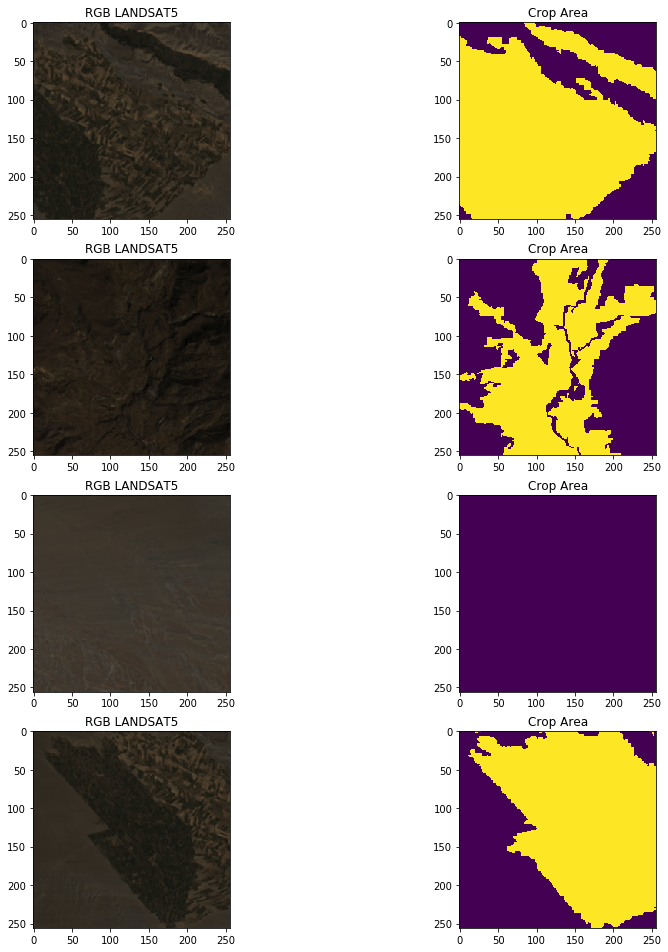

In [0]:
import matplotlib.pyplot as plt
import numpy as np

display_num = 5
plt.figure(figsize=(14, 21))

c=0
for i in range(1, display_num):
  for x in test_dba.take(i):
    x  
  tensor = tf.squeeze(x[0]).numpy()[:,:,[3,1,0]]
  target = tf.squeeze(x[1])

  #print(target.sum())  
  plt.subplot(display_num, 2, c + 1)
  plt.imshow(tensor)
  plt.title("RGB LANDSAT5")
  
  plt.subplot(display_num, 2, c + 2)
  plt.imshow(target)
  plt.title("Crop Area")
  c+=2 
plt.show()

### 4.7 Set up

Let’s begin by setting up some constant parameters. 

In [0]:
IMG_SHAPE  = (256, 256, 4)
EPOCHS = 10

### 4.8. Creating a U-NET model with keras
(For very complete guide about convolution arithmetic see [this paper](https://arxiv.org/pdf/1603.07285.pdf?)).

Here you will create a  convolutional neural network model with:
- 5 encoder layers.
- 5 decoder layer.
- 1 output layer.

The **encoder layer** is composed of a linear stack of `Conv`, `BatchNorm`, and `Relu` operations followed by a `MaxPool`. Each `MaxPool` will reduce the spatial resolution of our feature map by a factor of 2. We keep track of the outputs of each block as we feed these high-resolution feature maps with the decoder portion. 

The **decoder layer** is comprised of `UpSampling2D`, `Conv`, `BatchNorm`, and `Relu`. Note that we concatenate the feature map of the same size on the decoder side. Finally, we add a final Conv operation that performs a convolution along the channels for each individual pixel (kernel size of (1, 1)) that outputs our final segmentation mask in grayscale.



Additionally, Early Stopping, Tensorboard, and best model callback were added. A callback is a set of functions to be applied at given stages of the training procedure. You can found more details [here](https://keras.io/callbacks/).


In [0]:
from tensorflow.keras import layers

def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

inputs = layers.Input(shape=IMG_SHAPE)
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8
center = conv_block(encoder4_pool, 1024)
# center
decoder4 = decoder_block(center, encoder4, 512)
# 16
decoder3 = decoder_block(decoder4, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

### 4.9 Define your model

Using functional API, you must define your model by specifying the inputs and outputs associated with the model.



In [0]:
from tensorflow.keras import models
model = models.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### 4.10. Defining custom metrics and loss functions

Defining loss and metric functions are simple with Keras. Simply define a function that takes both the True labels for a given example and the Predicted labels for the same given example. 

**Dice loss** is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf), where it was introduced. We use dice loss here because it **performs better at class imbalanced problems by design**. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly. 

In [0]:
from tensorflow.keras import losses

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
  loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
  return loss

### 4.11 Compiling the model

We use our custom loss function to minimize. In addition, we specify what metrics we want to keep track of as we train. Note that metrics are not actually used during the training process to tune the parameters, but are instead used to measure performance of the training process. 

In [0]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

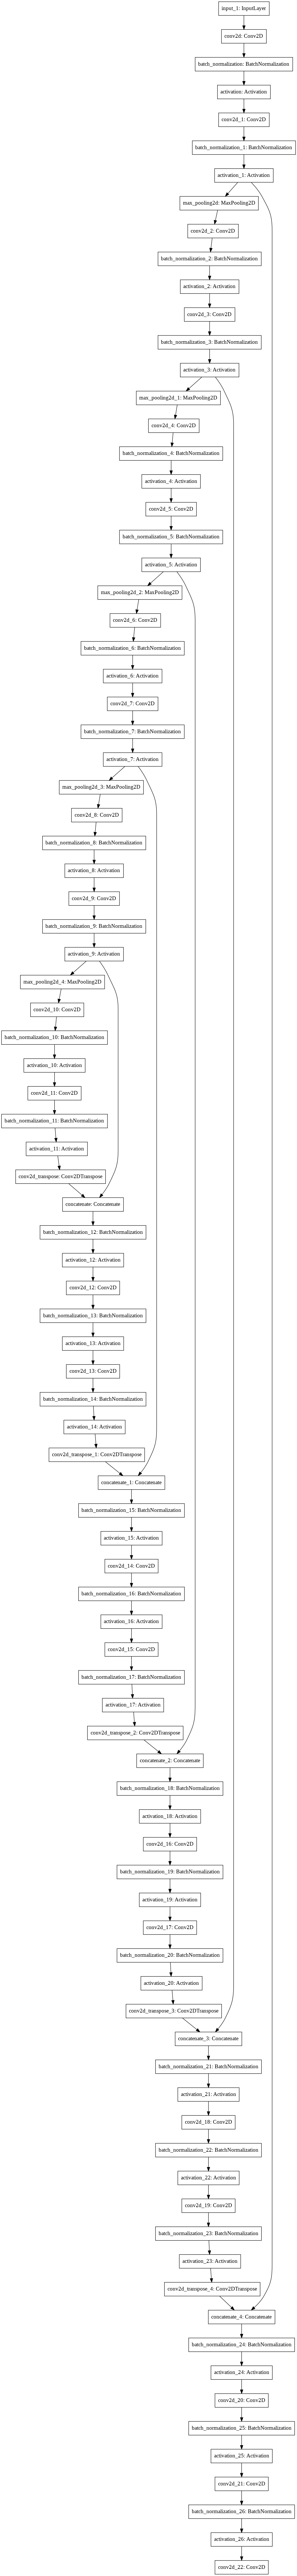

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model)

### 4.12 Training the model (OPTIONAL)

Training your model with `tf.data` involves simply providing the model's `fit` function with your training/validation dataset, the number of steps, and epochs.  

We also include a Model callback, [`ModelCheckpoint`](https://keras.io/callbacks/#modelcheckpoint) that will save the model to disk after each epoch. We configure it such that it only saves our highest performing model. Note that saving the model capture more than just the weights of the model: by default, it saves the model architecture, weights, as well as information about the training process such as the state of the optimizer, etc.

In [0]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime

# Callbacks time
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es = EarlyStopping(monitor='val_loss', patience=10)
mcp = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [0]:
N_train = 550
batch_size = 3

# Train the model I just do it for 15 minutes
history = model.fit(train_dba,
                    steps_per_epoch= int(np.ceil(N_train / float(batch_size))),
                    epochs=EPOCHS,
                    validation_data=test_dba,
                    callbacks=[tensorboard_callback,es,mcp])

In [0]:
%tensorboard --logdir logs
#!kill 607

### 4.13 Loading a Pretrained model (3 epochs)


In [0]:
import urllib
url = 'https://storage.googleapis.com/bag_csaybar/unet/best_model.h5'
urllib.request.urlretrieve(url, 'best_model.h5')

('best_model.h5', <http.client.HTTPMessage at 0x7f37f4990ba8>)

In [0]:
model.load_weights("best_model.h5")
model.evaluate(x = test_dba)

### 4.14. Prediction

You will prepare the L5 imagery, likewise, you made it for the train/test dataset. 

In [0]:
l5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")\
               .filterBounds(Camana_valley)\
               .filterDate('2005-01-01', '2006-12-31')\
               .filter(ee.Filter.lt('CLOUD_COVER', 20))\
               .map(maskS2clouds)\
               .median()\
               .multiply(0.0001)

l5_ndvi = l5.normalizedDifference(NDVI_bands).rename(['NDVI'])
l5_rgb = l5.select(RGB_bands).rename(['R','G','B']) 
l5 = l5_rgb.addBands(l5_ndvi)

In [0]:
from collections import OrderedDict

# Vizualize the dataset
l5id = l5.clip(Camana_valley.buffer(2500)).getMapId({'max':0.6,'min':0})
center = Camana_valley.centroid().getInfo()['coordinates']
center.reverse()
Mapdisplay(center,{'l5id':l5id},zoom_start=11)

For export the results to the Google Cloud Storage, it's preferred defines the following `formatOptions` parameters to save memory:

- **patchDimensions**:	Patch dimensions tiled over the export area, covering every pixel in the bounding box exactly once (except when the patch dimensions do not evenly divide the bounding box in which case the lower and right sides are trimmed).

- **compressed**: If true, compresses the .tfrecord files with gzip and appends the ".gz" suffix	

See all the paramerters [here](https://developers.google.com/earth-engine/exporting#configuration-parameters).

In [0]:
outputBucket = 'bag_csaybar'
imageFilePrefix = 'unet/Predict_CamanaValleyCrop'

# Specify patch and file dimensions.
imageExportFormatOptions = {
  'patchDimensions': [256, 256],
  'compressed': True
}

# Setup the task.
imageTask = ee.batch.Export.image.toCloudStorage(
  image=l5,
  description='Image Export',
  fileNamePrefix=imageFilePrefix,
  bucket=outputBucket,
  scale=30,
  fileFormat='TFRecord',
  region=Camana_valley.buffer(2500).getInfo()['coordinates'],
  formatOptions=imageExportFormatOptions,
)

imageTask.start()

In [0]:
import time 
while imageTask.active():
  print('Polling for task (id: {}).'.format(imageTask.id))
  time.sleep(5)

Polling for task (id: AQR7NDPVCU6SX3BEFB7AIPHL).
Polling for task (id: AQR7NDPVCU6SX3BEFB7AIPHL).
Polling for task (id: AQR7NDPVCU6SX3BEFB7AIPHL).
Polling for task (id: AQR7NDPVCU6SX3BEFB7AIPHL).
Polling for task (id: AQR7NDPVCU6SX3BEFB7AIPHL).
Polling for task (id: AQR7NDPVCU6SX3BEFB7AIPHL).
Polling for task (id: AQR7NDPVCU6SX3BEFB7AIPHL).
Polling for task (id: AQR7NDPVCU6SX3BEFB7AIPHL).
Polling for task (id: AQR7NDPVCU6SX3BEFB7AIPHL).


Now it's time to classify the image that was exported from GEE to GCS using Tensorflow. If the exported image is large (it not your case), it will be split into multiple TFRecord files in its destination folder. There will also be a JSON sidecar file called **"the mixer"** that describes the format and georeferencing of the image. Here we will find the image files and the mixer file, getting some info out of the mixer that will be useful during model inference.

In [0]:
filesList = !gsutil ls 'gs://'{outputBucket}'/unet/'
exportFilesList = [s for s in filesList if imageFilePrefix in s]

# Get the list of image files and the JSON mixer file.
imageFilesList = []
jsonFile = None
for f in exportFilesList:
  if f.endswith('.tfrecord.gz'):
    imageFilesList.append(f)
  elif f.endswith('.json'):
    jsonFile = f

# Make sure the files are in the right order.
print(jsonFile)

gs://bag_csaybar/unet/Predict_CamanaValleyCrop.json


The mixer contains metadata and georeferencing information for the exported patches, each of which is in a different file. Read the mixer to get some information needed for prediction.

In [0]:
import json
from pprint import pprint 

# Load the contents of the mixer file to a JSON object.
jsonText = !gsutil cat {jsonFile}
# Get a single string w/ newlines from the IPython.utils.text.SList
mixer = json.loads(jsonText.nlstr)
pprint(mixer)

{'patchDimensions': [256, 256],
 'patchesPerRow': 2,
 'projection': {'affine': {'doubleMatrix': [0.00026949458523585647,
                                            0.0,
                                            -72.80234523395521,
                                            0.0,
                                            -0.00026949458523585647,
                                            -16.552896414356777]},
                'crs': 'EPSG:4326'},
 'totalPatches': 2}


The next function  is slightly different from the to the `input_fn` (see Section 4.5). Mainly, this is because the pixels are written into records as patches, we need to read the patches in as one big tensor (one patch for each band), then flatten them into lots of little tensors.  Once the `predict_input_fn` is defined, that can handle the shape of the image data, all you need to do is feed it directly to the trained model to make predictions.


In [0]:
def predict_input_fn(fileNames,side,bands):
  
  # Read `TFRecordDatasets` 
  dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')

  featuresDict = {x:tf.io.FixedLenFeature([side, side], dtype=tf.float32) for x in bands}
     
  # Make a parsing function
  def parse_image(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
    return parsed_features
  
  def stack_images(features):         
    nfeat = tf.transpose(tf.squeeze(tf.stack(list(features.values()))))    
    return nfeat
 
  dataset = dataset.map(parse_image, num_parallel_calls=4)
  dataset = dataset.map(stack_images, num_parallel_calls=4)   
  dataset = dataset.batch(side*side)

  return dataset

In [0]:
predict_db = predict_input_fn(fileNames=imageFilesList,side=256,bands=['R', 'G', 'B', 'NDVI'])
predictions = model.predict(predict_db)

Now that there's a `np.array` of probabilities in "predictions", it's time to write them back into a file. You will write directly from TensorFlow to a file in the output Cloud Storage bucket.

Iterate over the list and write the probabilities in patches. Specifically, we need to write the pixels into the file as patches in the same order they came out. The records are written as serialized tf.train.Example protos. This might take a while.

In [0]:
# Instantiate the writer.
PATCH_WIDTH , PATCH_HEIGHT = [256,256]
outputImageFile = 'gs://' + outputBucket + '/unet/CamanaValleyCrop.TFRecord'
writer = tf.io.TFRecordWriter(outputImageFile)

# Every patch-worth of predictions we'll dump an example into the output
# file with a single feature that holds our predictions. Since our predictions
# are already in the order of the exported data, the patches we create here
# will also be in the right order.
curPatch = 1
for  prediction in predictions:
  patch = prediction.squeeze().T.flatten().tolist()
  
  if (len(patch) == PATCH_WIDTH * PATCH_HEIGHT):
    print('Done with patch ' + str(curPatch) + '...')    
    # Create an example
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'crop_prob': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=patch))
        }
      )
    )
    
    writer.write(example.SerializeToString())    
    curPatch += 1 

writer.close()

Done with patch 1...
Done with patch 2...


### 4.15 Upload the classifications to an Earth Engine asset

At this stage, there should be a predictions TFRecord file sitting in the output Cloud Storage bucket. Use the gsutil command to verify that the predictions image (and associated mixer JSON) exist and have non-zero size.




In [0]:
!gsutil ls -l {outputImageFile}

    524382  2019-07-20T06:02:04Z  gs://bag_csaybar/unet/CamanaValleyCrop.TFRecord
TOTAL: 1 objects, 524382 bytes (512.09 KiB)


Upload the image to Earth Engine directly from the Cloud Storage bucket with the [earthengine command](https://developers.google.com/earth-engine/command_line#upload). Provide both the image TFRecord file and the JSON file as arguments to earthengine upload.



In [0]:
# REPLACE WITH YOUR USERNAME:
USER_NAME = 'csaybar'
outputAssetID = 'users/' + USER_NAME + '/CamanaCrop_UNET'
print('Writing to ' + outputAssetID)

Writing to users/csaybar/CamanaCrop_UNET


In [0]:
# Start the upload. It step might take a while.
!earthengine upload image --asset_id={outputAssetID} {outputImageFile} {jsonFile}

Started upload task with ID: DFAMO6IXFLRLMUDRFMWPZIAT


Display the Results using Folium!

In [0]:
ProbsImage = ee.Image(outputAssetID)
predictionsImage = ee.Image(outputAssetID).gte(0.500)
dicc = {'CropProbability':ProbsImage.getMapId({'min':0.49,'max':0.498}),
        'Crop':predictionsImage.getMapId()}

center = Camana_valley.centroid().getInfo()['coordinates']
center.reverse()

Mapdisplay(center=center,dicc=dicc,zoom_start=13)

### That's all for this time!, the next post is about sequential models and Earth Engine.